## Baseline one object dataset
Testing dataset with one object of random shape and color in very easy rendering (basically for making sure that the model architecture works)

In [15]:
import numpy as np

import sampling
from evaluation import evaluate_sample
from environment import grab_frame, reset_env, create_shape

frame_size = (64, 64)
dataset_path = 'data/baseline_dataset'

def sample_func():        
    obj = sampling.ObjectOnTable.sample(origin=(0, 0, 1.0), max_bounds=(0, 0, 0), max_rotation=2 * np.pi, size=2.0)
    
    predicates = sampling.get_on_table_relation(obj, None, add_positional=False)
    predicates.extend(sampling.get_false_predicates(predicates, 1))

    reset_env()    
    create_shape(obj.obj_type, obj.color, obj.position, obj.orientation, obj.size)    
    frame = grab_frame(cam_pos=(0, -5, 1), cam_target=(0, 0, 1), light_dir=(-6, 1, 10), frame_size=frame_size)
    
    return frame, predicates

In [4]:
# Run only once!
from batching import create_dataset
create_dataset(dataset_path, 32, 128, sample_func)

Generating 32 * 128 = 4096 samples


100%|███████████████████████████████████████████| 32/32 [00:39<00:00,  1.23s/it]


In [16]:
# Run only once!
create_dataset(dataset_path + "_testing", 8, 128, sample_func)

Generating 8 * 128 = 1024 samples


100%|█████████████████████████████████████████████| 8/8 [00:25<00:00,  3.24s/it]


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

frame_inputs = layers.Input(shape=(*frame_size, 3))
x = layers.Rescaling(1.0 / 255.0)(frame_inputs)

for size in (8, 8, 8):
    x = layers.Conv2D(size, 3, padding="same", activation='relu')(x)
    x = layers.MaxPooling2D(2, padding="same")(x)        

x = layers.Flatten()(x)
conv_branch_outputs = layers.Dense(64, activation='relu')(x)

predicate_inputs = layers.Input(shape=(33,))
predicate_branch_outputs = layers.Dense(64, activation='relu')(predicate_inputs)

x = layers.concatenate([conv_branch_outputs, predicate_branch_outputs], axis=-1)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model([frame_inputs, predicate_inputs], outputs)
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 8)    224         rescaling_1[0][0]                
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [8]:
from batching import load_as_tf_dataset
training_set = load_as_tf_dataset(dataset_path).shuffle(128).batch(32)
testing_set = load_as_tf_dataset(dataset_path + "_testing").batch(32)

In [9]:
%%time
progress = model.fit(training_set, validation_data=testing_set, epochs=5)

Epoch 1/5


2021-11-09 12:12:11.738427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-09 12:12:13.325948: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-09 12:12:13.971278: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


256/256 [==============================] - 6s 12ms/step - loss: 0.4796 - accuracy: 0.7864 - val_loss: 0.1618 - val_accuracy: 0.9731
Epoch 2/5
256/256 [==============================] - 3s 11ms/step - loss: 0.0720 - accuracy: 0.9879 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 3/5
256/256 [==============================] - 3s 11ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 4/5
256/256 [==============================] - 3s 11ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/5
256/256 [==============================] - 3s 11ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
CPU times: user 16.7 s, sys: 1.98 s, total: 18.6 s
Wall time: 18 s


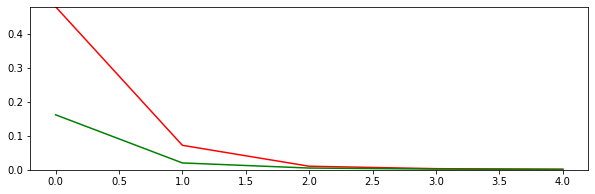

In [10]:
from utils import draw_progress
draw_progress(progress, fit_line=False)

In [11]:
from evaluation import evaluate_sample
probes = sampling.get_on_table_probes(add_positional=False)

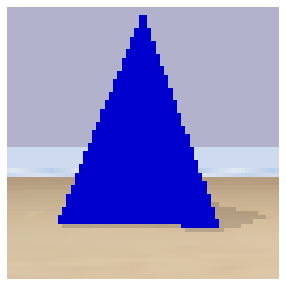

(blue pyramid on table) 1.0
(green sphere on table) 0.0
---
(blue pyramid on table) 0.9995127


In [13]:
evaluate_sample(sample_func, model, probes)